# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div> 

- **Training** 
    - Train-Test Split
    - Cross Validation
- **Hypertuning**
     - Optuna
     - Trade-Off Bias/Variance
     - Save Model

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Training</p></div> 

In [1]:
%%capture
%run part03_preparation.ipynb

In [2]:
#Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning Models
from lightgbm import LGBMClassifier

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
import optuna

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

import pickle
from datetime import datetime

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
X.shape, y.shape

((87245, 19), (87245,))

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((69796, 19), (69796,), (17449, 19), (17449,))

In [5]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))   

In [6]:
def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC']) 
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    #print(f"AUC: {auc:.4f}\n\n")     
   
    return y_prob, auc

In [7]:
def CVS(model, X, y, model_dict=''):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]    
    threshold = 0.5    
    y_pred = np.where(y_prob >= threshold, 1, 0)
    
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

In [8]:
lgbm_model = LGBMClassifier(random_state=RANDOM_SEED)

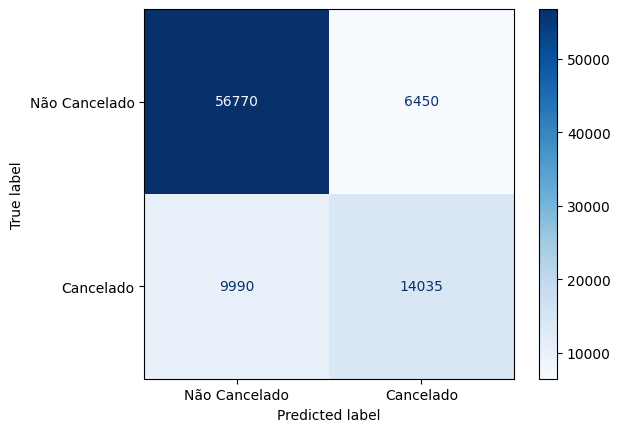

Score: 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87     63220
           1       0.69      0.58      0.63     24025

    accuracy                           0.81     87245
   macro avg       0.77      0.74      0.75     87245
weighted avg       0.80      0.81      0.81     87245



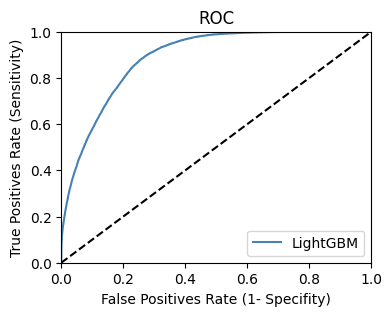

,value,std
fit_time,0.153374,0.009047
score_time,0.047253,0.030793
test_accuracy,0.811565,0.001204
train_accuracy,0.822546,0.000486
test_precision,0.685157,0.003314
train_precision,0.708601,0.002625
test_recall,0.584183,0.004580
train_recall,0.604027,0.006805
test_f1,0.630638,0.002742
train_f1,0.652113,0.002996


In [9]:
lgbm_y_prob, lgbm_y_pred  = CVS(lgbm_model,X,y,'LightGBM')

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

In [10]:
def objective(trial):
    
    weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),        
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        #'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        #'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [weight]),
        'seed': trial.suggest_categorical('scale_pos_weight', [RANDOM_SEED]),
        #'metric': trial.suggest_categorical('metric', ['auc']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        #'early_stopping_rounds':10,
        #'verbosity':0,
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)#random_state=RANDOM_SEED
    #scores = cross_val_score(model, X, y, cv=Kfold, scoring="precision")
    #return scores.mean()
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    return f1_score(y,y_pred)   

In [11]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=500);

trial = study.best_trial

[I 2023-06-23 10:44:35,138] A new study created in memory with name: no-name-1fd99647-1925-4a1d-95f7-33a20dbc1a33


In [12]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.6972483187878585

Optimized parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.07704585455334494, 'reg_alpha': 0.0007254995183099685, 'reg_lambda': 0.05720275662181285, 'subsample_freq': 7, 'min_child_samples': 10, 'scale_pos_weight': 2.631}



## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Trade of Bias/Variance</p></div>

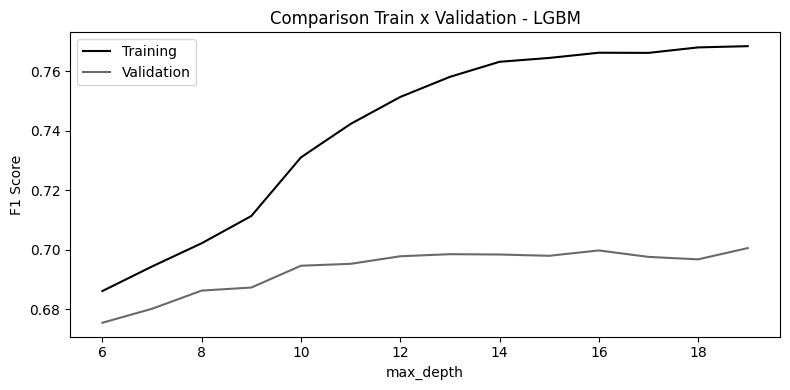

In [13]:
aux = lgbm_best_params
aux.pop('max_depth', None)

param_range = np.arange(6, 20, 1)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, max_depth = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("max_depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

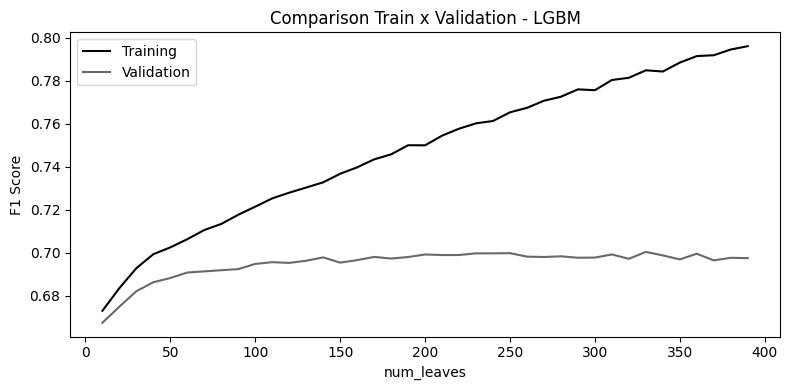

In [14]:
aux = lgbm_best_params.copy()
aux.pop('num_leaves', None)

param_range = np.arange(10, 400, 10)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, num_leaves = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("num_leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

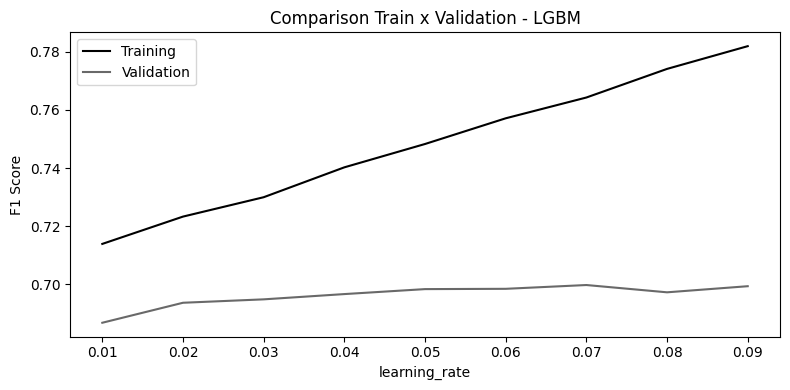

In [15]:
aux = lgbm_best_params.copy()
aux.pop('learning_rate', None)

param_range = np.arange(0.01, 0.1, 0.01)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, learning_rate = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("learning_rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

In [16]:
lgbm_best_params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'num_leaves': 280,
 'learning_rate': 0.07704585455334494,
 'reg_alpha': 0.0007254995183099685,
 'reg_lambda': 0.05720275662181285,
 'subsample_freq': 7,
 'min_child_samples': 10,
 'scale_pos_weight': 2.631}

In [17]:
lgbm_best_params_revised = {'objective': 'binary', 
                             'boosting_type': 'gbdt', 
                             'num_leaves': 200, 
                             'max_depth': 12, 
                             'learning_rate': 0.075, 
                             'reg_alpha': 0.0020, 
                             'reg_lambda': 0.25, 
                             'subsample_freq': 1, 
                             'min_child_samples': 1, 
                             'scale_pos_weight': 2.631}

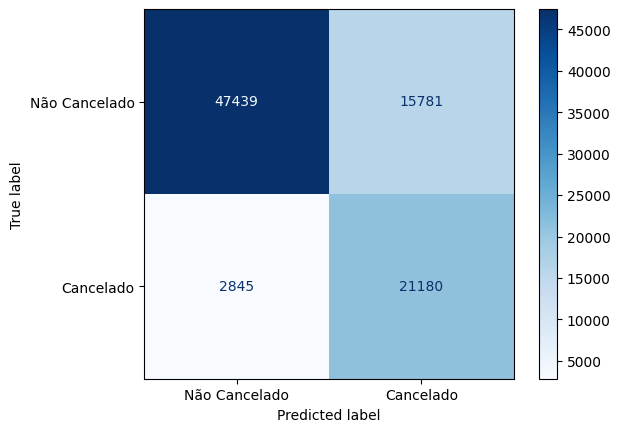

Score: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84     63220
           1       0.57      0.88      0.69     24025

    accuracy                           0.79     87245
   macro avg       0.76      0.82      0.77     87245
weighted avg       0.84      0.79      0.80     87245



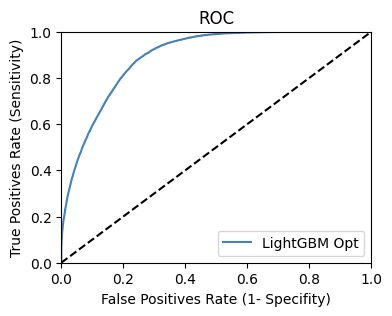

,value,std
fit_time,0.433195,0.024448
score_time,0.043860,0.001738
test_accuracy,0.786509,0.001330
train_accuracy,0.818225,0.001705
test_precision,0.573050,0.002049
train_precision,0.610586,0.002483
test_recall,0.881582,0.004569
train_recall,0.938418,0.000793
test_f1,0.694585,0.001255
train_f1,0.739807,0.001810


In [18]:
model_lgbm_tuned = LGBMClassifier(**lgbm_best_params_revised)
model_lgbm_tuned.fit(X,y)
y_prob_lgbm_tuned, y_pred_lgbm_tuned = CVS(model_lgbm_tuned,X,y,'LightGBM Opt')

In [19]:
results = data.copy()
results['lgbm_prob'] = y_prob_lgbm_tuned
results['lgbm_pred'] = y_pred_lgbm_tuned
results

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes,lgbm_prob,lgbm_pred
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,2.0,0.0,0,Portugal,Native,0.258218,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,2.0,0.0,0,Portugal,Native,0.305957,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1.0,0.0,1,United Kingdom,Europe,0.022102,0.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1.0,0.0,1,United Kingdom,Europe,0.047155,0.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,1,Check-Out,2015-07-03,2.0,0.0,2,United Kingdom,Europe,0.026855,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87240,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,Check-Out,2017-09-06,2.0,0.0,7,Belgium,Europe,0.006514,0.0
87241,City Hotel,0,102,2017,August,35,31,2,5,3,...,2,Check-Out,2017-09-07,3.0,0.0,7,France,Europe,0.845938,1.0
87242,City Hotel,0,34,2017,August,35,31,2,5,2,...,4,Check-Out,2017-09-07,2.0,0.0,7,Germany,Europe,0.661274,1.0
87243,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,Check-Out,2017-09-07,2.0,0.0,7,United Kingdom,Europe,0.038160,0.0


In [20]:
path = "/home/alysson/projects/Hotel-Booking-Cancelations/models/lgbm/"
filename = "lgbm_" + str(datetime.now().strftime("%d-%m-%y")) + str(".pkl")
filepath = str(path) + str(filename)

In [21]:
with open(filepath, 'wb') as file:
    model_lgbm_tuned.fit(X,y)    
    pickle.dump(model_lgbm_tuned, file)

In [22]:
model_lgbm_tuned

LGBMClassifier(learning_rate=0.075, max_depth=12, min_child_samples=1,
               num_leaves=200, objective='binary', reg_alpha=0.002,
               reg_lambda=0.25, scale_pos_weight=2.631, subsample_freq=1)